In [ ]:
# DS776 Auto-Update (runs in ~2 seconds, only updates when needed)
# If this cell fails, see Lessons/Course_Tools/AUTO_UPDATE_SYSTEM.md for help
%run ../Course_Tools/auto_update_introdl.py

In [15]:
from introdl import (model_report,
                     generate_top_k_table, 
                     generate_greedy_decoding_table, 
                     generate_detailed_beam_search, 
                     generate_top_k_sampling, 
                     generate_top_p_sampling,
                     plot_top_k_distribution, 
                     visualize_conversation,
                     config_paths_keys,
                     wrap_print_text
    )

from IPython.display import display, HTML, clear_output, Markdown
import gc # for memory management
import pandas as pd
from openai import OpenAI
import os
import re
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

print = wrap_print_text(print, width = 100)
paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

✅ Environment: Unknown Environment | Course root: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776
   Using workspace: <DS776_ROOT_DIR>/home_workspace

📂 Storage Configuration:
   DATA_PATH: <DS776_ROOT_DIR>/home_workspace/data
   MODELS_PATH: /home/jbaggett/DS776_new/Lessons/Lesson_11_Text_Generation/Lesson_11_Models (local to this notebook)
   CACHE_PATH: <DS776_ROOT_DIR>/home_workspace/downloads
🔑 API keys: 9 loaded from home_workspace/api_keys.env
🔐 Available: ANTHROPIC_API_KEY, GEMINI_API_KEY, GOOGLE_API_KEY... (9 total)
✅ HuggingFace Hub: Logged in
✅ Loaded pricing for 339 OpenRouter models
✅ Cost tracking initialized ($9.14 credit remaining)
📦 introdl v1.6.52 ready



## What is a text-generation model?

Modern text-generation models are advanced AI systems designed to produce coherent and contextually relevant text based on a given input or prompt. They operate using an auto-regressive approach, where the model predicts the next word or token in a sequence based on the preceding ones. This iterative process continues until the desired length of text is generated, allowing the model to create fluid and natural-sounding language. These models are widely used in applications such as chatbots, content creation, and 
language translation.

In this notebook we:
1. give an optional brief chronological history to text generation
2. summarize a sample of recent models
3. examine the computational cost of text generation
4. discuss how text generation models are trained
5. introduce chat roles and how chatbots work
6. demonstrate the decoding strategies discussed in the textbook and discuss their use cases
7. show how to use local and api-based models with various decoding strategies
8. discuss how LLMs can be adapted for specialized use using fine-tuning and/or retrieval augmented generation (RAG)

There's a ton of material here, but much of it can be skimmed and treated as background.  I'll note which sections are important and will be included in the homework so you know where to focus your energy and time.  Your main focus should be on sections 5-8.  There's also a bit of homework related to section 3.

**Note:** Throughout this lesson we avoid using `llm_generate` from the course package.  Rather we show you how to use local and API-based models directly. We also show you how to create your own helper functions, similar to `llm_generate` for simplifying API use. 


### Why APIs for Production?

In practice, most text generation applications use LLMs through **APIs** (Application Programming Interfaces) rather than loading models locally. Here's why:

**Desktop Hardware Limitations:**
- Modern LLMs require 8-48GB+ of VRAM for inference
- Consumer GPUs (e.g., RTX 4090 with 24GB) can only run up to ~13B parameter models at full precision
- Most laptops/desktops cannot run state-of-the-art models (70B+ parameters)

**API Advantages:**
- Access to cutting-edge models (GPT-5, Claude, Gemini, Llama 70B+) without expensive hardware
- Auto-scaling: no need to manage infrastructure
- Pay-per-use: cost only for actual usage
- Easy switching between models and providers
- Organizations who need private LLMs can host them on a local server with API access
- Local models run much faster using Ollama or VLLM which provide API access

**OpenAI-Compatible APIs:**
Most modern LLM APIs follow the OpenAI Chat Completions format, making it easy to:
- Use the same code across different providers (OpenAI, Anthropic, Google, etc.)
- Switch providers by changing one parameter
- Access models via gateways like OpenRouter that aggregate many providers

**HuggingFace's Role:**
HuggingFace Transformers is primarily used for:
- **Fine-tuning models** on custom data (most important use case)
- **Research and experimentation** with model internals
- **Learning** how LLMs work under the hood
- **Self-hosting models** when needed for privacy/control

**Our Approach in This Lesson:**
We'll start by demonstrating text generation with HuggingFace Transformers using smaller local models (3B-8B parameters). This helps you understand:
- How tokenization works
- What decoding strategies do
- How model outputs are probability distributions

Then we'll transition to API-based generation, which is what you'll use in real applications. By understanding the mechanics first, you'll make better decisions about decoding parameters when using APIs.


---

## **1. Chronology of Text Generation Approaches**

*This is a background section so just skim it.*

The evolution of text generation models reflects broader trends in natural language processing. Early models used statistical techniques, later enhanced by neural networks, recurrent architectures, and finally, transformers. The last few years have seen dramatic improvements with large-scale pre-training, instruction tuning, and the emergence of reasoning models and agents.

<details> 
<summary>If you're interested, you can CLICK HERE to see a detailed chronology.</summary>

---

### **Pre-2010s: Statistical Models and Rule-Based Systems**  
Early text generation systems relied on **statistical language models**, **n-grams**, and **rule-based methods**.

- **Markov Chains and N-grams:** These models generated text by predicting the next word based on the previous $n$ words, but they suffered from data sparsity and limited context.
- **Probabilistic Context-Free Grammars (PCFGs):** Used for structured text generation, especially in dialogue systems and machine translation.
- **2000s:** Phrase-based machine translation systems were common, particularly for tasks like translating short texts or building dialogue systems.

---

### **2010s: Neural Networks and Recurrent Architectures**  
The advent of deep learning dramatically improved text generation by learning complex patterns from large corpora.

- **2013–2014:** **Word Embeddings (Word2Vec, GloVe)** became standard for representing words in continuous vector space.
- **2014:** **Sequence-to-Sequence Models (Seq2Seq):** Introduced for machine translation and text generation using **LSTM (Long Short-Term Memory) networks**. Encoder-decoder architectures became foundational.
- **2015:** **Attention Mechanism:** Proposed by Bahdanau et al., allowing models to focus on specific parts of the input text, improving translation quality.
- **2015–2017:** **Variational Autoencoders (VAEs)** and **Generative Adversarial Networks (GANs)** explored for creative text generation but proved challenging to train.

---

### **Late 2010s: Transformers and Pre-trained Language Models**  
The introduction of transformers revolutionized text generation by enabling parallelized training and capturing long-range dependencies more effectively.

- **2017:** **Transformer Architecture (Vaswani et al.)** replaced recurrent networks with fully attention-based models, significantly improving machine translation and text generation.
- **2018:** **GPT (Generative Pre-trained Transformer):** OpenAI introduced a transformer-based, autoregressive language model pre-trained on a large corpus of text and fine-tuned for various tasks.
- **2019:** **GPT-2:** Scaled up the GPT architecture, achieving impressive text generation quality with zero-shot and few-shot capabilities.
- **2019:** **BERT:** Though primarily designed for understanding tasks, it influenced later models with its transformer-based architecture.

---

### **2020s: Large Language Models (LLMs), Instruction Tuning, Reasoning Models, and Agents**  
The 2020s have been dominated by progressively larger models trained with more sophisticated techniques to improve coherence, factuality, reasoning ability, and alignment with user intent.

---

#### **A. Large Language Models (LLMs)**
- **2020:** **GPT-3:** With 175 billion parameters, GPT-3 demonstrated strong few-shot learning capabilities. It became the basis for a wide range of text generation applications.
- **2021:** **T5 (Text-To-Text Transfer Transformer):** Unified NLP tasks by framing them all as text-to-text problems, paving the way for more versatile models.
- **2021–2022:** **Instruction Fine-Tuning:** Models are fine-tuned with human-labeled data to better follow instructions (e.g., InstructGPT).
- **2022:** **RLHF (Reinforcement Learning from Human Feedback):** Fine-tuning models using human preference data to improve alignment and quality.
- **2023:** **ChatGPT (GPT-4):** Demonstrated robust instruction-following abilities and multi-turn conversation handling, trained using both supervised fine-tuning and RLHF.
- **2023:** **LLaMA (Large Language Model Meta AI):** Released by Meta as a series of smaller, efficient models showing that high performance could be achieved with relatively fewer parameters.
- **2024–2025:** **LLaMA 3, Claude, Gemini:** Improved performance through better instruction-tuning, architecture modifications, and incorporating multimodal training data (text, images, code, etc.).

---

#### **B. Reasoning Models**  
The growing interest in making LLMs better at reasoning, planning, and performing multi-step tasks led to new architectures and training techniques.

- **2022:** **Chain-of-Thought (CoT) Prompting:** Improving reasoning by asking models to generate intermediate reasoning steps rather than answering directly.
- **2023:** **Self-Consistency Decoding:** Sampling multiple reasoning paths and selecting the most consistent one, improving robustness in reasoning tasks.
- **2024:** **Tree-of-Thoughts (ToT):** Extending Chain-of-Thought reasoning to generate, evaluate, and prune multiple reasoning paths in a structured manner.
- **2025:** **Multimodal Reasoning:** Incorporating images, code, and structured data into reasoning models for broader capabilities.

---

#### **C. Agents and Autonomy**  
Recent advances have enabled LLMs to act as **autonomous agents**, performing complex tasks by interacting with tools and environments.

- **2023:** **AutoGPT, BabyAGI:** Experimental frameworks designed to give LLMs autonomy in pursuing goals by generating sub-goals, retrieving information, and producing results over multiple steps.
- **2024:** **Toolformer (Meta):** A model that learns to use external tools (e.g., calculators, APIs) through fine-tuning, expanding the range of tasks it can handle.
- **2025:** **AgentBench:** Benchmarks developed to test LLMs acting as agents, including their ability to solve multi-step tasks with planning and reasoning.

---
</details>

### Chronology Summary Table

| Phase                | Key Techniques                               | Notable Models & Frameworks                            |
|----------------------|----------------------------------------------|-------------------------------------------------------|
| **Pre-2017**         | N-grams, RNNs, Word Embeddings, Attention    | Word2Vec, GloVe, Seq2Seq, LSTM, GRU                  |
| **2017-2019**        | Transformers, Auto-regressive Pre-training   | GPT, GPT-2, BERT, Transformer                        |
| **2020-2023**        | Large LMs, Instruction Tuning, RLHF          | GPT-3, ChatGPT, LLaMA, Claude, Gemini, InstructGPT   |
| **2024-2025**        | Reasoning, Multimodal, International Models  | GPT-4o, Claude 3, Qwen 2.5, DeepSeek, LLaMA 3        |
| **2025**             | Reasoning Models, Agentic AI                 | o1, o3, DeepSeek-R1, Agentic Frameworks, Tool Use   |

---


## **2. State-of-the-art Text Generation Models**

*The first part of this section will help you better understand how text-generation models (LLMs) work.  So at least watch the video.*

State-of-the-art text generation models, or LLMs, are auto-regressive, decoder-only architectures designed to predict the next token in a sequence based on prior context. These models leverage the transformer architecture, which uses self-attention mechanisms to capture long-range dependencies in text. 

Here's a picture I adapted from our textbook showing a typical decoder-only architecture:

<img src="pictures/Decoder_Example.png" alt="Decoder Example" width="1000">

Even with recent developments in resoning models, for now at least they still rely on the same transformer decoder architecture pictured here but use Chain-of-Thought prompting and generate multiple reasoning paths before selecting the most consistent result.

In the video below I discuss a few of the things in this picuture, including what "auto-regression" means, what those "token predictions" are, and how the final output token is determined.

#### L11_1_Text_Generation_Decoders Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_text_generation_decoders/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_text_generation_decoders/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/lq84nRLeB3K" target="_blank">Open Descript version of video in new tab</a>


### A Snapshot of Current Models

*This section is background, though you'll need to use some of the numbers from the table below in the homework.*

I tend to geek out on LLMs so the following table very likely falls under the category of TMI ("Too Much Information"), but it's sample of some of the recent models in this space.  All of these models have been fine-tuned to follow instructions.  The DeepSeek-V3 model is the most advanced the table - it is designed to excel in reasoning tasks and it uses mixture-of-experts approach to dynamically select a subset of "expert" networks for each task.

<details>
<summary>CLICK HERE to see a table of some recent LLMs</summary>

| **Feature**                 | **LLaMA 3.3 70B Instruct** | **Llama 3.1 8B Instruct** | **DeepSeek-V3**          | **Qwen 2.5 (72B)**       | **GPT-4o Mini**         | **GPT-4o**               |
|-----------------------------|----------------------------|---------------------------|--------------------------|--------------------------|-------------------------|--------------------------|
| **Model Type**              | Open Source                | Open Source               | Open Source  | Open Source              | Proprietary             | Proprietary              |
| **Parameters**              | 70 billion                 | 8 billion                 | 671 billion (37B active) | 72.7 billion             | ?    | $\approx$ 200 billion            |
| **Transformer Layers**      | 80                         | 40                        | 61  | 80 | Not specified            | Not specified            |
| **Embedding Size**     | 16,384                     | 4,096                     | 7,168?                 | 8,192                    | unknown | 12,288 |
| **Vocabulary Size**         | 128,000 tokens             | 128,000 tokens            | 150,000 tokens           | 160,000 tokens           | 200,000 tokens          | 200,000 tokens           |
| **Context Window**          | 8,000 tokens               | 128,000 tokens            | 128,000 tokens           | 131,072 tokens           | 128,000 tokens          | 128,000 tokens           |
| **Maximum Output Tokens**   | 2,048 tokens               | 2,048 tokens              | 2,048 tokens             | 2,048 tokens             | 16,384 tokens           | 16,384 tokens            |
| **Reasoning Task Accuracy** | 44%                        | Not specified             | 55%                      | 60%                      | 69%                     | 80%+ (best performer)    |
| **Mathematical Tasks**      | Moderate                   | Not specified             | Strong                   | Strong                   | Moderate                | High (55%)               |
| **Coding Tasks (HumanEval)**| Strong performance         | Not specified             | Strong performance       | Very Strong              | Moderate                | High performance         |                  |
| **Cost (Input Tokens)**     | $0.23 per million tokens   | Not specified             | $0.20 per million tokens | $0.25 per million tokens | $0.15 per million tokens| $0.25 per million tokens |
| **Cost (Output Tokens)**    | $0.40 per million tokens   | Not specified             | $0.35 per million tokens | $0.40 per million tokens | $0.60 per million tokens| $10 per million tokens   |
| **Open Source Availability**| Yes (Customizable)         | Yes (Customizable)        | Yes (Customizable)       | Yes (Restricted)         | No                      | No                      |
| **Best For**                | Coding tasks, cost-effective | Multilingual dialogue, general-purpose | General-purpose, coding | Multilingual, mathematics, reasoning | Reasoning, multitasking | Broad tasks, high performance across all benchmarks |
| **Released By**             | Meta                       | Meta                      | DeepSeek                 | Alibaba                  | OpenAI                  | OpenAI                   |
| **Year Released**           | 2025                       | 2024                      | 2025                     | 2025                     | 2024                    | 2024                     |

</details>

---


## **3. Compute Cost for LLMs or Why is Text-Generatation so Slow?**

*There will be a related homework problem or two.  You don't have to understand all of the formulas here, but do get a general idea how they work and what quantities are involved as it will help you better understand transfomers.*

#### L11_1_Text_Generation_Cost Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_text_generation_cost/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_text_generation_cost/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/89oyNf51xPP" target="_blank">Open Descript version of video in new tab</a>


By now you've probably noticed that text generation is much slower than using an already trained model for text-classification and NER tagging.  There are two main reasons for this:

1. LLMs are auto-regressive and require a forward model call for each new token.
2. Even small LLMs are much bigger models than task specific models like BERT.

To better understand the computational cost of transformers we can approximate the number of FLOPs or floating point operations used by a forward pass of transformer model.  This means we're counting the number of additions, subtractions, multiplications, and divisions.  The FLOPs count is dominated by the attention, feed-forward layers, and the final output layer. In particular we count the number of operations involved in each of the matrix multiplications. The other layers such as the normalization layers and activation functions are negligible. 

We won't derive the formulas here, but we'll give you some formulas for estimating the total FLOPs.  You can find details of these computations this article [How to Calculate the Number of FLOPS in Transformer Based Models](https://www.gaohongnan.com/playbook/training/how_to_calculate_flops_in_transformer_based_models.html#estimating-flops-for-a-single-forward-pass-of-gpt-2)

We'll use the following variables:
* $S$: length of the input sequence
* $D$: the embedding dimension (length of the embedding vectors and hidden states)
* $L$: number of transformer layers
* $N$: number of outputs (the number of logits from output layer after all the transformer layers)
* $T$: the number of embeddings passed through the final output layer (usually this is $S$ but not always)

We assume that the feed-forward network hidden layer has $4D$ neurons which is the typical size.

With that notation, the number of FLOPs from a single transformer layer is about
$$ 24 S D^2 + 4 S^2 D.$$

Notice the $S^2$ term.  This means that the cost is quadratic in the sequence length which is why extending transformers to handle very large input sequences (large context length) is difficult.

If we have $L$ transformer layers, then the FLOPs for processing a sequence through the transformer layers is 
$$L (24 S D^2 + 4 S^2 D).$$

This formula can be used for any architecture that uses transformer layers, whether an encoder or a decoder.

The final output layer can be significant, especially for text generation because the number of outputs is the vocabulary size and we pass all the embeddings through the output layer.  The number of FLOPs is 
$$2DTN.$$

In the case of text-generation model the whole sequence of embeddings is passed through the output layer so $T=S$ and the number of outputs is $V$, the vocabulary size so the number of FLOPs for the output layer is
$$2DSV.$$

To generate 1 token of new text thus requires
$$L (24 S D^2 + 4 S^2 D) + 2 D S V \text{ FLOPs}.$$

We truly don't expect you to understand how this formula is derived (but if you can that will advance your understanding of transformers).  Instead, we present the formula so you can see what the main contributions to the costs of using LLMs are.  Bigger models and longer sequences for context are great, but they come with increased costs.  A bigger model means more layers (larger $L$), increased embedding dimension (larger $D$), and perhaps a larger vocabulary ($V$).  Increasing context length means longer sequences ($S$).  

### Example: Generate 1 Token with LLama 3.1 8B

Let's suppose we have an input prompt with 200 tokens and we want to generate a single token of output.  For Llama 3.1 8B the relevant numbers are:

- **Parameters:** 8 billion
- **Transformer Layers (L):** 40
- **Embedding Dimension (D):** 4096
- **Vocabulary Size (V):** 128,000 tokens
- **Initial Prompt (S):** 200 tokens

We can use Python to do the math:

In [1]:
L = 40
D = 4096
S = 200
V = 128_000

def flops_one_token(L, D, S, V):
    return L*(24*S*D**2 + 4*S**2*D) + 2*D*S*V

FLOPs = flops_one_token(L, D, S, V)

print(f"FLOPs for generating 1 token: {FLOPs:,} or {FLOPs:.2e}")

FLOPs for generating 1 token: 3,457,155,072,000 or 3.46e+12


Wow!  That's about 3.5 trillion FLOPs to generate one token using the LLaMa 3.1 8B model.  While the formulas may not mean much wihout studying them, at least appreciate how large these numbers get.

Now if we want to generate 100 new tokens from based on an input prompt of length 200 tokens, then because the text generation is auto-regressive we need to first compute the FLOPs for an input sequence of length 200, then 201, then 202, all the way up to 299.

#### Example: Generate 100 New Tokens with LLaMa 3.1 8B

We'll use the same values as the previous example including the initial prompt with length 200.  Now we'll use a loop to add up the FLOPs for input sequences of length $200, 201, \ldots 299$

In [2]:
L = 40
D = 4096
V = 128_000

FLOPs_gen_100 = 0
for S in range(200,300):
    FLOPs_gen_100 += flops_one_token(L, D, S, V)
print(f"Total FLOPs for generating 100 tokens (S=200 to S=299): {FLOPs_gen_100:,} or {FLOPs_gen_100:.2e}")

Total FLOPs for generating 100 tokens (S=200 to S=299): 432,144,089,088,000 or 4.32e+14


That's 432 trillion FLOPs and 100 forward model passes which shows explains it takes a bit of time to generate text on our compute servers.

Let's compare that to the estimated number of FLOPs to do NER tagging for a 100 token sequence like we did last week for the CoNLL2023 data (BIO tagging: B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, B-MISC, I-MISC, O).  

#### Example: Tagging a 100 Token Sequence using the BERT-base model

The BERT-base-cased model has about 110 million parameters, $L=12$ transformer layers, an embedding size of $D = 768$. For the final output layer we pass the whole sequence $S=100$ through the layer and map it to 9 possible tags which would be like using a vocabulary size $V=9$.  Let's plug that into our FLOPs estimator:

In [3]:
L = 12
D = 768
S = 100
V = 9

FLOPs_BERT = flops_one_token(L, D, S, V)
print(f"FLOPs for tagging a 100 token sequence with 9 possible tags using BERT-base: {FLOPs_BERT:,} or {FLOPs_BERT:.2e}")

FLOPs for tagging a 100 token sequence with 9 possible tags using BERT-base: 17,356,953,600 or 1.74e+10


How many times more FLOPs does it take to generate 100 new tokens of text than to tag a 100 token sequence?

In [4]:
print(f"FLOPs ratio for LLama-3.1-8B to BERT-base: {FLOPs_gen_100 / FLOPs_BERT:.2f}")

FLOPs ratio for LLama-3.1-8B to BERT-base: 24897.46


Not only do we need only 1 forward model pass for BERT-base to tag a sequence of 100 tokens compared to 100 serially executed model passes to generate 100 tokens of text.  The text generation model requires 25,000 times more FLOPs.  

**The Bottom Line:** While text-generating LLMs can be used as all purpose NLP tools, particularly when you don't have a lot of labeled data.  They're expensive to use and, as we've seen in the past few lessons, may not be as accurate as specialized transformer models for many NLP tasks.

## **4. Training a Text Generation Model (e.g., GPT, LLaMA, Gemini)**

*This section is background, but it's a good idea to have some idea of what goes into training the chatbots that most of use daily at this point.*

To get a better understanding of LLMs and text generation it helps to know how these models are trained.  In this section we'll break down the training process into **Pre-training**, **Instruction Fine-Tuning**, and **Learning Human Preferences**—all tailored to **Auto-Regressive Models**.

<details>
<summary>CLICK here for an outline of the training methods or at least look at the table below.</summary>

### **1. Pre-training (Self-Supervised Learning)**

**Objective:** Learn general language patterns, structure, grammar, facts, and broad knowledge from a large, diverse dataset.

####  **Process:**
- **Model Type:** Auto-Regressive Model (e.g., GPT, LLaMA, GPT-NeoX).
- **Dataset:** Huge corpus of **unlabeled text data** from diverse sources such as:
  - Books
  - Wikipedia
  - News articles
  - Forums, Websites, Code repositories
  - Social media posts (if applicable)
  
- **Training Objective:** **Next Token Prediction** (Auto-regressive Language Modeling)
  - Given a sequence of tokens $x_1, x_2, \ldots, x_{t-1}$, predict the next token $x_t$.
  - The model learns to maximize the probability:
    $$
    P(x_t | x_1, x_2, \ldots, x_{t-1})
    $$
  - This is done by minimizing the **Cross-Entropy Loss** over the entire dataset.
  
- **Optimization:** 
  - **AdamW** optimizer with **Gradient Clipping** and **Learning Rate Scheduling**.
  - Mixed-precision training (`fp16` or `bfloat16`) to reduce memory usage.
  
- **Hardware:** Multiple GPUs or TPUs due to the size of the model and dataset.

#### **Output:** 
A general-purpose language model that can generate coherent text based on general language understanding but is not specialized or aligned with specific tasks.


### **2. Fine-Tuning (Instruction Training with Labeled Data)**

**Objective:** Adapt the general-purpose model to **follow human instructions** and perform specific tasks more effectively.

#### **Process:**
- **Model Type:** Same architecture as pre-training (e.g., GPT-style).
- **Dataset:** **Labeled instruction-following data**, consisting of:
  - **Prompt-Response Pairs**: Text prompts paired with human-provided responses.
  - **Task Descriptions:** Instructions for tasks the model is expected to perform (e.g., summarization, translation, question answering, etc.).
  - **Open-ended Prompts:** Where the model generates text continuations based on creative or complex prompts.
  
- **Training Objective:** **Supervised Fine-Tuning**
  - The model is trained to generate appropriate responses to instructions.
  - This is typically done by minimizing the **Cross-Entropy Loss** over the labeled dataset.
  - The training objective remains the same:
    $$
    P(y_1, \ldots, y_n | x_1, \ldots, x_m)
    $$
    Where $x$ is the instruction and $y$ is the desired output.

- **Optimization:** 
  - Lower learning rates compared to pre-training.
  - Shorter training duration (often just a few epochs).
  
- **Hardware:** Fewer resources required than pre-training, but still typically done on GPUs.

#### **Output:** 
A model that is **better aligned with user prompts and can follow instructions effectively**. It can perform various tasks like:
- **Question Answering**
- **Summarization**
- **Translation**
- **Creative Writing**


### **3. Learning Human Preferences (Alignment with Human Feedback)**

**Objective:** Make the model produce helpful, accurate, and safe outputs that match what humans prefer.

#### **Process:** 
This step is called **Reinforcement Learning from Human Feedback (RLHF)**, but we can break it down into simpler parts:

#### **A. Collecting Human Feedback**
- **Collect examples** of good responses for different prompts.
- **Ask humans to rank outputs** from the model from best to worst (for example, when given the same prompt, which response is most helpful or safest?).

#### **B. Training a Scoring Model (Reward Model)**
- Build a separate model called a **Reward Model**.
- Train it to **score outputs based on human feedback** (higher score = better response).
- The model learns to predict what humans would rank as good responses.

#### **C. Improving the Original Model**
- Now, we use the scores from the **Reward Model** to help the original model improve.
- The original model is adjusted to produce outputs that get higher scores from the **Reward Model**.
- This helps the model generate responses that are more helpful, accurate, and aligned with human values.

### **Output:** 
A model that produces higher-quality and safer responses by learning from human feedback.

</details>

### **Summary Table**

| Phase          | Objective                         | Data Type                         | Training Method                           | Output                                    |
|----------------|-----------------------------------|----------------------------------|-----------------------------------------|-----------------------------------------|
| **Pre-training**      | General language understanding   | Unlabeled text corpus            | Auto-regressive Language Modeling       | General-purpose LLM |
| **Instruction Fine-Tuning** | Instruction following         | Labeled instruction-response pairs | Supervised Fine-Tuning                  | Task-specific model, better at following instructions |
| **RLHF (Alignment)** | Align with human preferences    | Human preference pairs           | Reinforcement Learning (PPO)            | Model that aligns well with human intentions and preferences |


In practice your company or organization is unlikely to train an LLM from scratch.  They'll use an already trained model and adapt it for their purposes.  What that looks like will depend on the use-case and data-security concerns.  We'll discuss a couple of ways that LLMs are adapted at the end of this notebook.  

In the next section we'll concentrate on the final decoding step where the output of model is used to pick the next token in the sequence.

---

## **5. Chat Roles and Building Chatbots with APIs**

*This section introduces chat roles, explains their use with local models vs APIs, and demonstrates building production-quality chatbots using object-oriented design.*

*NOTE: this section was overhauled for Fall 2025 and doesn't, as yet, have a video.  I've tried to make it so a video isn't necessary, but will record one if time allows.*

### Understanding Chat Roles

When working with conversational AI, we structure interactions using **chat roles** to distinguish between different participants in the conversation:

- **System**: Provides instructions and context for the model's behavior
- **User**: Represents the person interacting with the model
- **Assistant**: Represents the model's responses

These roles are organized in a **messages list**, where each message is a dictionary with `"role"` and `"content"` keys:

```python
messages = [
    {"role": "system", "content": "You are a helpful Python tutor."},
    {"role": "user", "content": "What is a list comprehension?"},
    {"role": "assistant", "content": "A list comprehension is a concise way..."},
    {"role": "user", "content": "Can you show me an example?"}
]
```

This structure allows the model to:
- **Maintain context** across multiple turns of conversation
- **Follow specific instructions** provided in the system message
- **Generate contextually appropriate responses** based on conversation history


### Chat Roles with Local Models

**Chat roles CAN be used with local models**, but there are some important considerations:

**How it works with local models:**
- Local models use **chat templates** to format the messages list into a single prompt string
- Each model family has its own template format (Llama, Gemini, GPT-style, etc.)
- The template inserts special tokens to mark role boundaries
- When generating, the model outputs the entire formatted conversation including your prompt

**Example with local model:**
```python
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
]

# Apply chat template and generate
formatted = tokenizer.apply_chat_template(messages, tokenize=False)
inputs = tokenizer(formatted, return_tensors="pt")
outputs = model.generate(**inputs)
response = tokenizer.decode(outputs[0])  # Contains full conversation + new response
```

**Why local models with chat roles aren't commonly used in production:**
- **Output includes the full prompt** - You need to parse and extract just the assistant's response
- **Template complexity** - Different models require different formatting
- **Hardware requirements** - Running models locally requires expensive GPUs
- **Maintenance burden** - Managing model updates, templates, and inference infrastructure
- **Scalability** - Hard to scale to many concurrent users

**Where local models with chat roles ARE useful:**
- **Learning** how LLMs and chat templates work (great for education!)
- **Research** and experimentation with model behavior
- **Fine-tuning** models for specialized tasks
- **Privacy-critical applications** where data cannot leave your infrastructure


### Why APIs Are the Standard for Production LLM Applications

In practice, **APIs are the standard approach for nearly all production LLM usage** - not just chatbots, but text generation, embeddings, audio models, vision models, and more. This is true whether you're building chatbots, content generation tools, semantic search systems, or multimodal applications.

**Benefits of API-based models:**
1. **Clean responses** - APIs return only the generated output, no prompt repetition
2. **Automatic formatting** - Template handling and preprocessing done server-side
3. **State-of-the-art models** - Access to the latest models without expensive hardware
4. **Automatic scaling** - Handles varying loads without infrastructure management
5. **Simple integration** - One API format works across multiple models and providers
6. **Cost-effective** - Pay per use rather than maintaining GPUs
7. **Unified interface** - Same API for text, embeddings, audio, vision models

**The OpenAI API format has become the industry standard** implemented by most providers:
- **OpenAI** (GPT-4, GPT-4o, O1, embeddings, DALL-E, Whisper)
- **OpenRouter** (unified access to 100+ models from multiple providers)
- **Google AI** (Gemini models - text, vision, audio)
- **Anthropic** (Claude models)
- **Local providers** (Ollama, vLLM) also support this API format

**When organizations host their own LLMs**, they typically run them on local or cloud servers and access them via an API (usually OpenAI-compatible) rather than direct model loading.  A medium to large sized model like **Falcon-180B** (a 2023 decoder only model) requires 400-600 GB of video RAM to load the model weights in 16 bit precision and for overhead.  This means that 5 to 8 high end Nvidia GPUs with 80 GB of video RAM each are needed for inference.  For training, even more hardware is required.   (Note: [xAI's Collusus](https://x.ai/colossus) has over 200,000 of these GPUs and is still growing!)

In this section, we'll build a **chatbot** using **OpenRouter** as a practical example of API-based LLM usage, but these same principles apply to any LLM application you build.



### Loading API Keys with dotenv

Before making API calls, we need access to our API key. There are two ways to handle this:

**Method 1: Using dotenv** (explicit loading):
```python
from dotenv import load_dotenv
import os

# Load environment variables from ~/home_workspace/api_keys.env
load_dotenv(os.path.expanduser("~/home_workspace/api_keys.env"))

# Access the key
api_key = os.getenv("OPENROUTER_API_KEY")
```

**Method 2: Using introdl.config_paths_keys()** (automatic):
```python
from introdl import config_paths_keys

paths = config_paths_keys()
# API keys already loaded! Available via os.getenv()
api_key = os.getenv("OPENROUTER_API_KEY")
```

Since we've already called `config_paths_keys()` at the top of this notebook, our API keys are already available. Let's verify:


In [5]:
import os

# Check if OPENROUTER_API_KEY is loaded
api_key = os.getenv("OPENROUTER_API_KEY")
if api_key:
    print(f"✓ OPENROUTER_API_KEY loaded (length: {len(api_key)})")
    print(f"  First 10 chars: {api_key[:10]}...")
else:
    print("✗ OPENROUTER_API_KEY not found")
    print("  Make sure ~/home_workspace/api_keys.env contains:")
    print("  OPENROUTER_API_KEY=your_key_here")


✓ OPENROUTER_API_KEY loaded (length: 73)
  First 10 chars: sk-or-v1-0...


### How the OpenAI Chat Completions API Works

The OpenAI Chat Completions API has become the **standard interface** for LLM interactions. OpenRouter (and many other providers) use this same API format, making your code portable across providers.

**Basic Structure:**

```python
from openai import OpenAI

# Initialize client
client = OpenAI(
    api_key="your-api-key",
    base_url="https://openrouter.ai/api/v1"  # Or OpenAI, Google, etc.
)

# Make a request
response = client.chat.completions.create(
    model="google/gemini-2.5-flash-lite",  # Specify which model
    messages=[                              # Conversation history
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"}
    ]
)

# Extract response
assistant_message = response.choices[0].message.content
```

**Key Components:**
- **client**: Authenticated connection to the API
- **model**: Which LLM to use (provider/model-name format for OpenRouter)
- **messages**: List of conversation turns with roles (system/user/assistant)
- **response**: Contains generated text and metadata

This simple interface works across dozens of models and providers!


### What llm_generate() Does Under the Hood

Our `introdl.nlp.llm_generate()` function is essentially a wrapper around this API with added features like cost tracking, error handling, and JSON mode. Here's a simplified version showing the core concept:


In [16]:
from openai import OpenAI
import os

def simple_llm_generate(model, prompt, system_prompt=None, temperature=0.7):
    """
    Simplified version of llm_generate() showing the core API wrapper concept.

    Args:
        model: Model name (e.g., 'gemini-2.5-flash-lite' or 'google/gemini-2.5-flash-lite')
        prompt: User's input text
        system_prompt: Optional instructions for the model
        temperature: Randomness (0=deterministic, 1=creative)

    Returns:
        str: Model's response
    """
    # Initialize API client for OpenRouter
    client = OpenAI(
        api_key=os.getenv("OPENROUTER_API_KEY"),
        base_url="https://openrouter.ai/api/v1"
    )

    # Build conversation messages
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": prompt})

    # Make API request
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature
    )

    # Extract and return the response text
    return response.choices[0].message.content


# Test it
response = simple_llm_generate(
    model="google/gemini-2.5-flash-lite",
    prompt="Explain transformers in one sentence.",
    system_prompt="You are a concise technical assistant."
)
print(response)


Transformers are a type of neural network architecture that uses self-attention mechanisms to weigh
the importance of different input elements, enabling them to excel at processing sequential data
like text.


### How Chatbots Maintain Context

Before we build our chatbot class, let's understand **how chatbots work** under the hood.

**The key insight:** LLMs are stateless - they have no memory of previous interactions. Each API call is independent. So how do chatbots remember what you said earlier?

**The solution:** We maintain a **conversation history** by appending each user message and assistant response to a messages list. On every new turn, we send the **entire conversation** to the API:

```
Turn 1:
Send to API: [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What are transformers?"}
]
Response: "Transformers are neural network architectures..."

Turn 2:
Send to API: [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What are transformers?"},
    {"role": "assistant", "content": "Transformers are neural network architectures..."},
    {"role": "user", "content": "How do they work?"}  ← New message
]
Response: "They work using attention mechanisms that..."
```

**How it works:**
1. **User sends first message** → API generates response
2. **Append both messages** (user + assistant) to conversation history
3. **User sends second message** → Add to history, send ENTIRE conversation to API
4. **API sees full context** → Generates contextually appropriate response
5. **Repeat** for each turn

**Why this works:**
- The model sees the entire conversation each time
- It can reference earlier topics, maintain context, and provide coherent responses
- From the user's perspective, it "remembers" the conversation
- In reality, we're just sending increasingly long message lists

**Cost implication:**
- Each API call includes ALL previous messages
- Conversation cost grows with length (more input tokens)
- Long conversations may need truncation (keep recent N messages)

Now let's build a class that automates this process for us:


### Building a Chatbot Class

Now let's build something more useful: a `Conversation` class that:
- Manages conversation history automatically
- Handles multi-turn interactions
- Provides clean methods for chatting
- Displays conversations nicely

This demonstrates **object-oriented design** for building maintainable APIs:


In [25]:
from openai import OpenAI
import os
from introdl import visualize_conversation

class Conversation:
    """
    A chatbot class for managing multi-turn conversations with LLMs.

    Args:
        api_key (str): OpenRouter API key
        model (str): Model name (e.g., 'google/gemini-2.5-flash-lite')
        system_prompt (str, optional): Initial instructions for the model

    Example:
        chat = Conversation(
            api_key=os.getenv("OPENROUTER_API_KEY"),
            system_prompt="You are a helpful Python tutor."
        )
        response = chat.send("What is a list comprehension?")
        chat.display()
    """

    def __init__(self, api_key, model="gemini-2.5-flash-lite", system_prompt=None):
        self.client = OpenAI(
            api_key=api_key,
            base_url="https://openrouter.ai/api/v1"
        )

        self.model = model
        self.messages = []
        if system_prompt:
            self.messages.append({"role": "system", "content": system_prompt})

    def send(self, user_message):
        """
        Send a message and get a response.

        Args:
            user_message (str): The user's input

        Returns:
            str: The assistant's response
        """
        # Add user message to history
        self.messages.append({"role": "user", "content": user_message})

        # Get response from API
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.messages
        )

        # Extract assistant's message
        assistant_message = response.choices[0].message.content

        # Add to history
        self.messages.append({"role": "assistant", "content": assistant_message})

        return assistant_message

    def display(self, show_recent_only=True):
        """
        Show the conversation history with color-coded roles.

        Args:
            show_recent_only (bool): If True, show only recent exchange
        """
        visualize_conversation(self.messages, show_recent_only=show_recent_only)

    def reset(self, system_prompt=None):
        """Reset conversation history, optionally with new system prompt."""
        self.messages = []
        if system_prompt:
            self.messages.append({"role": "system", "content": system_prompt})

print("✓ Conversation class defined")


✓ Conversation class defined


### Example 1: Basic Multi-Turn Conversation

Let's recreate the conversation from Section 5, but now using our cleaner `Conversation` class:


In [18]:
# Create a chatbot
chat = Conversation(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    model="google/gemini-2.5-flash-lite",
    system_prompt="You are a helpful assistant. Answer questions concisely and clearly."
)

# First turn
response = chat.send("What are transformers in NLP?")
chat.display()


**👤 User:**

What are transformers in NLP?

---

**🤖 Assistant:**

In Natural Language Processing (NLP), **Transformers** are a type of neural network architecture that has revolutionized the field. They are particularly effective at handling sequential data like text.

Here's a breakdown of their key characteristics:

*   **Attention Mechanism:** The core innovation of Transformers is the **self-attention mechanism**. This allows the model to weigh the importance of different words in an input sequence when processing a particular word. Instead of processing words sequentially (like in RNNs), attention lets the model "look at" all words simultaneously and understand their relationships, regardless of their distance.

*   **Parallelization:** Unlike recurrent neural networks (RNNs) that process data step-by-step, Transformers can process all words in a sequence in parallel. This significantly speeds up training and inference.

*   **Encoder-Decoder Structure:** The original Transformer architecture consists of an **encoder** and a **decoder**.
    *   The **encoder** processes the input sequence and creates a rich, contextualized representation.
    *   The **decoder** then uses this representation to generate an output sequence (e.g., translating a sentence).

*   **Positional Encoding:** Since Transformers process words in parallel, they lose information about the order of words. To address this, they use **positional encodings**, which are vectors added to the input embeddings to give the model information about the position of each word in the sequence.

**Why are they important?**

Transformers have become the gold standard for many NLP tasks, including:

*   Machine Translation
*   Text Summarization
*   Question Answering
*   Text Generation
*   Sentiment Analysis

Famous models like **BERT**, **GPT-3**, and **T5** are all based on the Transformer architecture.

---



In [19]:
# Second turn (maintains context!)
response = chat.send("How do their attention mechanisms work?")
chat.display()


**👤 User:**

How do their attention mechanisms work?

---

**🤖 Assistant:**

The attention mechanism in Transformers allows the model to dynamically **weigh the importance of different parts of the input sequence relative to each other** when processing a specific element. This is crucial for understanding context.

Here's a simplified explanation of how it works, focusing on **Self-Attention**:

Imagine you have a sentence: "The animal didn't cross the street because it was too tired."

When the model processes the word "it," it needs to figure out what "it" refers to. Self-attention helps it do this.

1.  **Queries, Keys, and Values (Q, K, V):** For each word in the input sequence, the model generates three vectors:
    *   **Query (Q):** Represents what the current word is "looking for."
    *   **Key (K):** Represents what other words "offer" or "contain."
    *   **Value (V):** Represents the actual information or content of the word.

2.  **Calculating Attention Scores:**
    *   For a specific word (let's say "it"), its **Query** vector is multiplied (dot product) with the **Key** vectors of *all* other words in the sentence, including itself.
    *   This dot product produces a **score** indicating how relevant each word's Key is to the current word's Query. A higher score means higher relevance.

3.  **Softmax for Weights:**
    *   These raw scores are then passed through a **softmax function**. This converts the scores into a probability distribution, meaning they sum up to 1. These probabilities are the ** "attention weights."**
    *   For "it," the attention weights might show a high probability for "animal" and a lower probability for "street," indicating that "animal" is much more relevant to "it" in this context.

4.  **Weighted Sum of Values:**
    *   Finally, the **Value** vectors of all words are multiplied by their corresponding attention weights.
    *   These weighted Value vectors are then **summed up**. This resulting vector is the new, context-aware representation of the word. In this example, the resulting vector for "it" will be heavily influenced by the Value vector of "animal," effectively learning that "it" refers to "animal."

**In essence:**

*   Each word queries the other words to see how much attention they deserve.
*   It then uses that attention to create a new representation that incorporates information from the most relevant words.

This process is performed for every word in the sequence, allowing the model to build rich, context-aware representations for each token. The "multi-head attention" in Transformers simply means this process is done multiple times in parallel with different sets of Q, K, and V matrices, allowing the model to attend to different aspects of the relationships.

---



In [20]:
# Third turn
response = chat.send("Can you explain how they are trained?")
chat.display()


**👤 User:**

Can you explain how they are trained?

---

**🤖 Assistant:**

Transformers are trained using a process similar to other deep learning models, primarily through an objective function and optimization algorithms. Here's a breakdown of the typical training process:

1.  **Massive Datasets:** Transformers (especially large language models) require enormous amounts of text data for training. This data comes from various sources like books, websites, articles, and conversations. The sheer volume and diversity of this data are crucial for enabling the model to learn grammar, facts, reasoning abilities, and nuanced language patterns.

2.  **Objective Functions (Pre-training):** The most common training paradigm for Transformers is **pre-training**, followed by **fine-tuning**.
    *   **Pre-training** is an unsupervised or self-supervised learning phase where the model learns general language understanding from the unlabeled text data. Two key pre-training objectives are:
        *   **Masked Language Modeling (MLM):** A certain percentage of words in the input sequence are randomly "masked" (hidden). The model's task is to predict these masked words based on the surrounding *unmasked* words. This forces the model to learn bidirectional context and relationships between words. (e.g., BERT uses MLM).
        *   **Causal Language Modeling (CLM) / Next Token Prediction:** The model is trained to predict the next word in a sequence given the preceding words. This is a unidirectional approach, good for generative tasks. (e.g., GPT models use CLM).
        *   **Next Sentence Prediction (NSP) / Sentence Order Prediction (SOP):** Some models (like BERT) also predict whether two sentences follow each other logically or if they are randomly paired. This helps the model understand relationships between sentences.

3.  **Fine-tuning:** After pre-training, the Transformer model has a general understanding of language. It can then be **fine-tuned** on smaller, task-specific labeled datasets.
    *   For example, if you want to build a sentiment analysis model, you would take a pre-trained Transformer and train it on a dataset of movie reviews labeled as positive or negative.
    *   During fine-tuning, the model's weights are adjusted slightly to adapt its learned knowledge to the specific task. This is much more efficient than training a model from scratch for every new task.

4.  **Optimization Algorithms:**
    *   **Gradient Descent:** Like most neural networks, Transformers are trained using variants of gradient descent (e.g., Adam, AdamW). These algorithms iteratively adjust the model's parameters (weights and biases) to minimize the difference between the model's predictions and the actual target values (as defined by the objective function).
    *   **Backpropagation:** The error calculated by the objective function is propagated backward through the neural network to compute gradients, which then guide the parameter updates.

5.  **Computational Resources:** Training large Transformer models is computationally intensive and requires significant hardware resources, typically involving many GPUs or TPUs running in parallel for days or even weeks.

In summary, Transformers are trained by first learning general language patterns from vast amounts of text using self-supervised objectives like masked language modeling, and then adapting that knowledge to specific NLP tasks through fine-tuning on smaller, labeled datasets, all optimized through gradient descent.

---



To see the **full conversation history** at any time, call `display()` with the parameter `show_recent_only=False`


In [21]:
# Display entire conversation
chat.display(show_recent_only=False)

**🔧 System:**

> You are a helpful assistant. Answer questions concisely and clearly.

---

**👤 User:**

What are transformers in NLP?

---

**🤖 Assistant:**

In Natural Language Processing (NLP), **Transformers** are a type of neural network architecture that has revolutionized the field. They are particularly effective at handling sequential data like text.

Here's a breakdown of their key characteristics:

*   **Attention Mechanism:** The core innovation of Transformers is the **self-attention mechanism**. This allows the model to weigh the importance of different words in an input sequence when processing a particular word. Instead of processing words sequentially (like in RNNs), attention lets the model "look at" all words simultaneously and understand their relationships, regardless of their distance.

*   **Parallelization:** Unlike recurrent neural networks (RNNs) that process data step-by-step, Transformers can process all words in a sequence in parallel. This significantly speeds up training and inference.

*   **Encoder-Decoder Structure:** The original Transformer architecture consists of an **encoder** and a **decoder**.
    *   The **encoder** processes the input sequence and creates a rich, contextualized representation.
    *   The **decoder** then uses this representation to generate an output sequence (e.g., translating a sentence).

*   **Positional Encoding:** Since Transformers process words in parallel, they lose information about the order of words. To address this, they use **positional encodings**, which are vectors added to the input embeddings to give the model information about the position of each word in the sequence.

**Why are they important?**

Transformers have become the gold standard for many NLP tasks, including:

*   Machine Translation
*   Text Summarization
*   Question Answering
*   Text Generation
*   Sentiment Analysis

Famous models like **BERT**, **GPT-3**, and **T5** are all based on the Transformer architecture.

---

**👤 User:**

How do their attention mechanisms work?

---

**🤖 Assistant:**

The attention mechanism in Transformers allows the model to dynamically **weigh the importance of different parts of the input sequence relative to each other** when processing a specific element. This is crucial for understanding context.

Here's a simplified explanation of how it works, focusing on **Self-Attention**:

Imagine you have a sentence: "The animal didn't cross the street because it was too tired."

When the model processes the word "it," it needs to figure out what "it" refers to. Self-attention helps it do this.

1.  **Queries, Keys, and Values (Q, K, V):** For each word in the input sequence, the model generates three vectors:
    *   **Query (Q):** Represents what the current word is "looking for."
    *   **Key (K):** Represents what other words "offer" or "contain."
    *   **Value (V):** Represents the actual information or content of the word.

2.  **Calculating Attention Scores:**
    *   For a specific word (let's say "it"), its **Query** vector is multiplied (dot product) with the **Key** vectors of *all* other words in the sentence, including itself.
    *   This dot product produces a **score** indicating how relevant each word's Key is to the current word's Query. A higher score means higher relevance.

3.  **Softmax for Weights:**
    *   These raw scores are then passed through a **softmax function**. This converts the scores into a probability distribution, meaning they sum up to 1. These probabilities are the ** "attention weights."**
    *   For "it," the attention weights might show a high probability for "animal" and a lower probability for "street," indicating that "animal" is much more relevant to "it" in this context.

4.  **Weighted Sum of Values:**
    *   Finally, the **Value** vectors of all words are multiplied by their corresponding attention weights.
    *   These weighted Value vectors are then **summed up**. This resulting vector is the new, context-aware representation of the word. In this example, the resulting vector for "it" will be heavily influenced by the Value vector of "animal," effectively learning that "it" refers to "animal."

**In essence:**

*   Each word queries the other words to see how much attention they deserve.
*   It then uses that attention to create a new representation that incorporates information from the most relevant words.

This process is performed for every word in the sequence, allowing the model to build rich, context-aware representations for each token. The "multi-head attention" in Transformers simply means this process is done multiple times in parallel with different sets of Q, K, and V matrices, allowing the model to attend to different aspects of the relationships.

---

**👤 User:**

Can you explain how they are trained?

---

**🤖 Assistant:**

Transformers are trained using a process similar to other deep learning models, primarily through an objective function and optimization algorithms. Here's a breakdown of the typical training process:

1.  **Massive Datasets:** Transformers (especially large language models) require enormous amounts of text data for training. This data comes from various sources like books, websites, articles, and conversations. The sheer volume and diversity of this data are crucial for enabling the model to learn grammar, facts, reasoning abilities, and nuanced language patterns.

2.  **Objective Functions (Pre-training):** The most common training paradigm for Transformers is **pre-training**, followed by **fine-tuning**.
    *   **Pre-training** is an unsupervised or self-supervised learning phase where the model learns general language understanding from the unlabeled text data. Two key pre-training objectives are:
        *   **Masked Language Modeling (MLM):** A certain percentage of words in the input sequence are randomly "masked" (hidden). The model's task is to predict these masked words based on the surrounding *unmasked* words. This forces the model to learn bidirectional context and relationships between words. (e.g., BERT uses MLM).
        *   **Causal Language Modeling (CLM) / Next Token Prediction:** The model is trained to predict the next word in a sequence given the preceding words. This is a unidirectional approach, good for generative tasks. (e.g., GPT models use CLM).
        *   **Next Sentence Prediction (NSP) / Sentence Order Prediction (SOP):** Some models (like BERT) also predict whether two sentences follow each other logically or if they are randomly paired. This helps the model understand relationships between sentences.

3.  **Fine-tuning:** After pre-training, the Transformer model has a general understanding of language. It can then be **fine-tuned** on smaller, task-specific labeled datasets.
    *   For example, if you want to build a sentiment analysis model, you would take a pre-trained Transformer and train it on a dataset of movie reviews labeled as positive or negative.
    *   During fine-tuning, the model's weights are adjusted slightly to adapt its learned knowledge to the specific task. This is much more efficient than training a model from scratch for every new task.

4.  **Optimization Algorithms:**
    *   **Gradient Descent:** Like most neural networks, Transformers are trained using variants of gradient descent (e.g., Adam, AdamW). These algorithms iteratively adjust the model's parameters (weights and biases) to minimize the difference between the model's predictions and the actual target values (as defined by the objective function).
    *   **Backpropagation:** The error calculated by the objective function is propagated backward through the neural network to compute gradients, which then guide the parameter updates.

5.  **Computational Resources:** Training large Transformer models is computationally intensive and requires significant hardware resources, typically involving many GPUs or TPUs running in parallel for days or even weeks.

In summary, Transformers are trained by first learning general language patterns from vast amounts of text using self-supervised objectives like masked language modeling, and then adapting that knowledge to specific NLP tasks through fine-tuning on smaller, labeled datasets, all optimized through gradient descent.

---



### Example 2: How System Prompts Shape Behavior

System prompts dramatically affect the model's personality and response style. Let's compare two different personas answering the same question:


In [22]:
# Create a technical assistant
tech_chat = Conversation(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    model="google/gemini-2.5-flash-lite",
    system_prompt="""You are a precise technical expert. Provide detailed, accurate
    explanations with specific examples. Use technical terminology."""
)

response = tech_chat.send("What is recursion in programming?")
tech_chat.display(show_recent_only=True)


**👤 User:**

What is recursion in programming?

---

**🤖 Assistant:**

Recursion in programming is a powerful technique where a function solves a problem by calling itself. This self-referential behavior allows for elegant and often concise solutions to problems that can be broken down into smaller, self-similar subproblems.

The core of recursion lies in two essential components:

1.  **Base Case (or Termination Condition):** This is the condition that stops the recursion. Without a base case, the function would call itself indefinitely, leading to a stack overflow error. The base case represents the simplest instance of the problem that can be solved directly without further recursive calls.

2.  **Recursive Step:** This is the part of the function where it calls itself with a modified input, typically moving closer to the base case. The problem is broken down into a smaller, identical subproblem, and the function relies on itself to solve that subproblem. The result of the recursive call is then used to construct the solution to the original problem.

### How Recursion Works: The Call Stack

To understand how recursion operates, it's crucial to grasp the concept of the **call stack**. When a function is called, its local variables, parameters, and the return address are pushed onto the call stack. When the function returns, its frame is popped off the stack.

In recursion, each recursive call pushes a new frame onto the call stack. The function continues to call itself until it reaches the base case. Once the base case is hit, the function returns a value. This return value is then used by the calling function (which is a previous instance of the same recursive function) to complete its calculation. This process continues, with each function instance returning its result, until the initial call to the function finally returns.

### Illustrative Example: Factorial Calculation

A classic example to demonstrate recursion is the calculation of the factorial of a non-negative integer. The factorial of a number $n$ (denoted as $n!$) is the product of all positive integers less than or equal to $n$.

Mathematically, the factorial is defined as:
$n! = n \times (n-1) \times (n-2) \times ... \times 1$ for $n > 0$
$0! = 1$

We can express this definition recursively:
*   **Base Case:** If $n = 0$, the factorial is $1$.
*   **Recursive Step:** If $n > 0$, the factorial of $n$ is $n$ multiplied by the factorial of $(n-1)$.

Here's how this translates into a Python function:

```python
def factorial(n):
  # Base Case: If n is 0, return 1
  if n == 0:
    return 1
  # Recursive Step: If n > 0, return n times the factorial of (n-1)
  else:
    return n * factorial(n - 1)

# Example usage:
result = factorial(5)
print(f"The factorial of 5 is: {result}")
```

Let's trace the execution of `factorial(5)`:

1.  `factorial(5)` is called. Since $5 \neq 0$, it executes `return 5 * factorial(4)`.
2.  `factorial(4)` is called. Since $4 \neq 0$, it executes `return 4 * factorial(3)`.
3.  `factorial(3)` is called. Since $3 \neq 0$, it executes `return 3 * factorial(2)`.
4.  `factorial(2)` is called. Since $2 \neq 0$, it executes `return 2 * factorial(1)`.
5.  `factorial(1)` is called. Since $1 \neq 0$, it executes `return 1 * factorial(0)`.
6.  `factorial(0)` is called. This hits the **base case**, so it `return 1`.

Now, the return values propagate back up the call stack:

7.  `factorial(1)` receives `1` from `factorial(0)` and returns `1 * 1 = 1`.
8.  `factorial(2)` receives `1` from `factorial(1)` and returns `2 * 1 = 2`.
9.  `factorial(3)` receives `2` from `factorial(2)` and returns `3 * 2 = 6`.
10. `factorial(4)` receives `6` from `factorial(3)` and returns `4 * 6 = 24`.
11. `factorial(5)` receives `24` from `factorial(4)` and returns `5 * 24 = 120`.

The final result, `120`, is then printed.

### Another Example: Fibonacci Sequence

The Fibonacci sequence is another common recursive example. Each number in the sequence is the sum of the two preceding ones, usually starting with 0 and 1.

Mathematically:
*   $F(0) = 0$
*   $F(1) = 1$
*   $F(n) = F(n-1) + F(n-2)$ for $n > 1$

Here's the recursive Python implementation:

```python
def fibonacci(n):
  # Base Cases
  if n <= 0:
    return 0
  elif n == 1:
    return 1
  # Recursive Step
  else:
    return fibonacci(n - 1) + fibonacci(n - 2)

# Example usage:
result = fibonacci(7)
print(f"The 7th Fibonacci number is: {result}")
```

Tracing `fibonacci(4)`:

*   `fibonacci(4)` calls `fibonacci(3)` and `fibonacci(2)`.
*   `fibonacci(3)` calls `fibonacci(2)` and `fibonacci(1)`.
*   `fibonacci(2)` calls `fibonacci(1)` and `fibonacci(0)`.
*   The base cases ($n=0$ and $n=1$) return their values directly.
*   The results are summed up as they return from each recursive call.

This implementation, while elegant, is **highly inefficient** due to repeated calculations of the same subproblems (e.g., `fibonacci(2)` is calculated multiple times). This is a common drawback of naive recursive solutions and can be mitigated with techniques like memoization or dynamic programming.

### Advantages of Recursion:

*   **Elegance and Readability:** For problems that lend themselves to a recursive definition (like tree traversals, fractal generation, or certain mathematical functions), recursive code can be significantly more concise and easier to understand than iterative equivalents.
*   **Simplicity for Certain Data Structures:** Recursive solutions are often natural fits for processing recursive data structures like trees and linked lists, where operations can be defined in terms of operating on a node and then recursively processing its children or the rest of the list.
*   **Mirroring Mathematical Definitions:** When a problem's mathematical definition is inherently recursive, a recursive programming solution often closely mirrors that definition, making it intuitive.

### Disadvantages of Recursion:

*   **Stack Overflow:** Each recursive call consumes memory on the call stack. If the recursion is too deep (too many nested calls) or infinite, it can exhaust the stack space, leading to a stack overflow error.
*   **Performance Overhead:** Function call overhead (pushing and popping frames from the stack, parameter passing, etc.) can make recursive solutions slower than equivalent iterative solutions, especially for simple problems.
*   **Redundant Computations:** As seen with the Fibonacci example, a naive recursive approach can recompute the same subproblems many times, leading to exponential time complexity and severe performance degradation.
*   **Debugging Difficulty:** Tracing the execution flow of recursive functions can sometimes be more challenging than debugging iterative code.

### Tail Recursion

A special form of recursion is **tail recursion**. A recursive call is in tail position if it is the very last operation performed by the function before returning. The result of the tail-recursive call is directly returned without any further computation.

Example of a tail-recursive factorial (conceptually):

```python
def tail_recursive_factorial(n, accumulator=1):
  if n == 0:
    return accumulator
  else:
    # The recursive call is the last operation
    return tail_recursive_factorial(n - 1, n * accumulator)
```

Some compilers and interpreters can optimize tail-recursive functions to behave like loops, preventing the call stack from growing indefinitely. This optimization is known as Tail Call Optimization (TCO). However, TCO is not guaranteed in all programming languages (e.g., Python does not natively implement TCO).

In summary, recursion is a fundamental programming paradigm where a function calls itself to solve a problem. It requires a well-defined base case to ensure termination and a recursive step that breaks the problem into smaller, self-similar subproblems. While it offers elegant solutions for specific problem domains, it's important to be mindful of its potential performance implications and memory usage.

---



In [23]:
# Create a friendly tutor
friendly_chat = Conversation(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    model="google/gemini-2.5-flash-lite",
    system_prompt="""You are a friendly teacher explaining concepts to beginners.
    Use simple language, analogies, and encourage learning. Be warm and supportive."""
)

response = friendly_chat.send("What is recursion in programming?")
friendly_chat.display(show_recent_only=True)


**👤 User:**

What is recursion in programming?

---

**🤖 Assistant:**

Hey there! 👋 Let's talk about a really cool concept in programming called **recursion**. Don't worry, it sounds fancy, but it's actually quite intuitive once you get the hang of it.

Imagine you're trying to explain how to make a Russian nesting doll, but you're talking to someone who's never seen one before. You might say something like:

"To open a nesting doll, you take the biggest doll and open it. Inside, you'll find a **smaller nesting doll**. To open that smaller doll, you do the **exact same thing** – you open it. And guess what? Inside, you'll find an **even smaller nesting doll**! You keep doing this until you find the tiniest, solid doll."

See what's happening there? You're explaining the process by referring back to the **same process**, just on a smaller scale. This is the heart of recursion!

**In programming, recursion is when a function calls itself.**

Think of it like a set of mirrors facing each other. When you look into one mirror, you see a reflection of yourself, and in that reflection, you see another reflection, and another, and another... it goes on and on (theoretically!).

Here's the breakdown in simple terms:

1.  **A Function That Calls Itself:** A recursive function is like a recipe that includes a step to "make the same recipe, but with a slightly smaller version of the ingredients."

2.  **The "Base Case" (The Tiny Doll):** This is the MOST important part! Every recursive function needs a stopping condition, otherwise, it would go on forever (like an infinite loop!). This stopping condition is called the **base case**. In our nesting doll example, the base case is finding the tiniest, solid doll. Once you reach that, you stop opening.

3.  **The "Recursive Step" (The Smaller Doll):** This is the part where the function calls itself with a slightly modified input, making the problem smaller and moving closer to the base case. In the nesting doll example, this is opening the current doll to find the *smaller* doll inside.

**Why is this useful?**

Recursion can make complex problems simpler to understand and write, especially for tasks that involve breaking down large problems into smaller, self-similar sub-problems. Think about:

*   **Traversing tree-like structures:** Like navigating a file system or a family tree.
*   **Mathematical calculations:** Like calculating factorials (5! = 5 \* 4 \* 3 \* 2 \* 1) or the Fibonacci sequence (each number is the sum of the two preceding ones).
*   **Searching and sorting algorithms:** Some efficient ways to find things in data rely on recursion.

**Let's look at a super simple code example (don't worry if it looks a little strange at first!):**

Imagine we want to count down from a number to zero.

```python
def countdown(n):
  # Base Case: When n is 0 or less, we stop.
  if n <= 0:
    print("Blast off!")
  else:
    # Recursive Step: Print the current number and call countdown with n-1
    print(n)
    countdown(n - 1)

# Let's try it!
countdown(5)
```

If you run `countdown(5)`, here's what happens in your mind:

1.  `countdown(5)`: Prints 5. Calls `countdown(4)`.
2.  `countdown(4)`: Prints 4. Calls `countdown(3)`.
3.  `countdown(3)`: Prints 3. Calls `countdown(2)`.
4.  `countdown(2)`: Prints 2. Calls `countdown(1)`.
5.  `countdown(1)`: Prints 1. Calls `countdown(0)`.
6.  `countdown(0)`: Hits the base case (`n <= 0`), prints "Blast off!", and stops.

The output would be:
```
5
4
3
2
1
Blast off!
```

**Key Takeaways for Beginners:**

*   **It's like Russian nesting dolls:** A problem solved by solving a smaller version of itself.
*   **Always have a "base case":** This is the crucial stopping point to prevent infinite loops.
*   **It can make some problems elegant:** Sometimes it's the most natural way to express a solution.

Don't worry if it feels a bit mind-bending at first! The best way to learn recursion is to:

1.  **Understand the base case:** What's the simplest version of the problem that can be solved directly?
2.  **Understand the recursive step:** How does the problem get closer to the base case?
3.  **Trace the execution:** Mentally (or with `print` statements) follow how the function calls itself.

Keep practicing and exploring examples, and you'll be a recursion pro in no time! It's a powerful tool in your programming toolbox. 😊 Let me know if you'd like to try another example!

---



### Key Insights

**Why This Approach is Better than llm_generate:**
1. **Clean API**: `chat.send()` is more intuitive than managing message lists manually
2. **Automatic History**: No need to manually append messages
3. **Reusable**: Create multiple chatbots with different personalities
4. **Maintainable**: Easy to add features (logging, error handling, retries, etc.)

**Object-Oriented Benefits:**
- **Encapsulation**: Conversation state is contained in the object
- **Reusability**: Create multiple independent conversations
- **Extensibility**: Easy to subclass for specialized chatbots

**Production Considerations:**
- Add error handling for API failures
- Implement retry logic with exponential backoff
- Track token usage and costs
- Add conversation length management (trim old messages when approaching context limit)
- Consider streaming responses for better UX

This is exactly how professional SDKs (OpenAI, Anthropic, LangChain) structure their chatbot interfaces!



---

## **6. Decoding Strategies - Converting Probabilities to Tokens**

*This section is important.  Decoding methods shape the output of an LLM.  The methods in this section will be in the homework.*

#### L11_1_Decoding_Strategies Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_decoding_strategies/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_decoding_strategies/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/LQx3wLJEV1F" target="_blank">Open Descript version of video in new tab</a>


Decoding strategies are the main focus of the textbook so I'm not going to go into great detail on each of them, but I had a bit of trouble following the book in places and perhaps you did too.  I'm going to go through a series of demonstrations to try to help you get a bit of insight into the decoding strategies.  All of these strategies: greedy search, beam search, top_k search, and top_p search are available with local models and all but beam search are available in most API-based models.  Many commercial providers serve the same models that we can run locally, but don't expose or provide access to the beam search option for those models.

Throughout this section will make use of various functions we created in `helpers.py` that are imported near the top of this notebook.

**Note:**  We're not making use of chat_templates in this section to keep things simple.  But you can use chat_templates and assign roles with the different decoding strategies.  Using chat_templates will cause local models to output the whole conversation so you'll need to post-process to remove the output you don't want.


### Output of the Model

Let's review what the output of our decoder model is.  Given the current input sequence, the classification head maps the final hidden states of the transformer layers to logits, one for each possible token in the vocabulary.  Those logits are then passed through a softmax to get a probability distribution for the next possible token.  To demonstrate we'll load the quantized Llama-3.2-3B instruction fine-tuned model that we've used previously with `llm_generate`.  **You must have a GPU for this to work (use a compute server).**

In [26]:
# Instantiate model and tokenizer
model_name  = "unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model_report(model, tokenizer)


Model Report for llama
---------------------------
Vocabulary Size: 128256
Embedding Dimension: 3072
Number of Transformer Blocks: 28
Total Number of Parameters: 1,841,212,416


### Understanding Model Outputs: From Logits to Probabilities

*This next few cells were added for Fall 2025 because many of you have been asking for details instead of just using helper functions.  The original helper function assisted presentation from the video is further below.  This section will help you with the homework.

Let's understand what's happening under the hood when we work with language models.

**Key insight:** Language models output **logits** (raw scores), which we convert to **probabilities** using the softmax function. While models internally work with **log probabilities** for numerical stability (avoiding underflow when multiplying many small numbers), we'll display **raw probabilities** (values between 0 and 1) because they're more intuitive to understand.

Let's see how to extract and visualize these probabilities from model outputs.


In [41]:
# Example: Getting token probabilities from model output

# Define a prompt
prompt = "The future of artificial intelligence is"
input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(device)

# Get model output (without generating - just one forward pass)
with torch.no_grad():
    output = model(input_ids)

# Extract logits for the next token (last position in sequence)
logits = output.logits[0, -1, :]  # Shape: [vocab_size]
print(f"Logits shape: {logits.shape}")
print(f"Logits are raw scores - can be any value: {logits[:5]}")

# Convert logits to probabilities using softmax
probabilities = torch.softmax(logits, dim=-1)
print(f"\nProbabilities shape: {probabilities.shape}")
print(f"Probabilities sum to 1.0: {probabilities.sum():.6f}")
print(f"Probabilities range from 0 to 1: min={probabilities.min():.6f}, max={probabilities.max():.6f}")

# Get top 10 most likely next tokens
top_probs, top_ids = torch.topk(probabilities, k=10)

print(f"\nTop 10 most likely next tokens:")
print(f"{'Token':<20s} {'Probability':<12s} {'Percentage'}")
print("-" * 50)
for prob, token_id in zip(top_probs, top_ids):
    token = tokenizer.decode(token_id)
    print(f"{token:<20s} {prob.item():<12.6f} {prob.item()*100:6.2f}%")


Logits shape: torch.Size([128256])
Logits are raw scores - can be any value: tensor([4.9570, 2.8340, 0.5142, 1.2646, 0.9521],
device='cuda:0',
       dtype=torch.float16)

Probabilities shape: torch.Size([128256])
Probabilities sum to 1.0: 0.999512
Probabilities range from 0 to 1: min=0.000000, max=0.156738

Top 10 most likely next tokens:
Token                Probability  Percentage
--------------------------------------------------
 uncertain           0.156738      15.67%
 bright              0.106873      10.69%
 a                   0.102783      10.28%
 not                 0.048157       4.82%
 being               0.036072       3.61%
 exciting            0.035248       3.52%
 looking             0.028763       2.88%
 here                0.027664       2.77%
 in                  0.020233       2.02%
 an                  0.017715       1.77%


**What we just did:**

1. **Got raw logits** from the model (unnormalized scores)
2. **Applied softmax** to convert to probabilities that sum to 1.0
3. **Extracted top tokens** using `torch.topk()`

The softmax function converts any set of real numbers into a probability distribution:

```
softmax(x_i) = exp(x_i) / sum(exp(x_j) for all j)
```

This is how the model decides which token to generate next - it samples from this probability distribution.


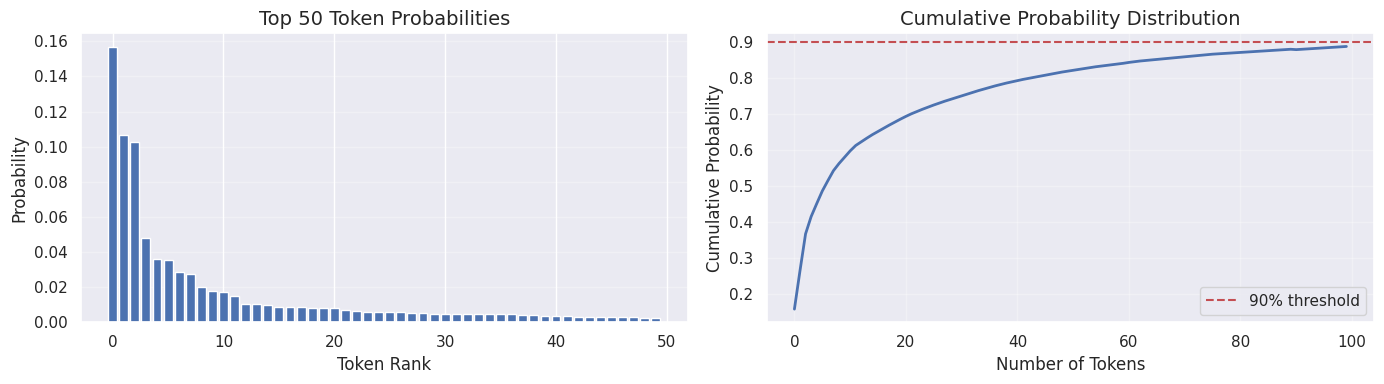


Probability mass coverage:
Top 10 tokens cover 58.0% of probability
Top 50 tokens cover 82.0% of probability
Top 100 tokens cover 88.9% of probability


In [42]:
# Visualize the probability distribution

import matplotlib.pyplot as plt

# Sort all probabilities in descending order
sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)

# Plot top 50 tokens
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Bar chart of top 50 probabilities
ax1.bar(range(50), sorted_probs[:50].cpu().numpy())
ax1.set_xlabel('Token Rank', fontsize=12)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_title('Top 50 Token Probabilities', fontsize=14)
ax1.grid(axis='y', alpha=0.3)

# Cumulative probability
cumsum = torch.cumsum(sorted_probs, dim=0)
ax2.plot(range(100), cumsum[:100].cpu().numpy(), linewidth=2)
ax2.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Tokens', fontsize=12)
ax2.set_ylabel('Cumulative Probability', fontsize=12)
ax2.set_title('Cumulative Probability Distribution', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Show how many tokens cover various probability masses
print(f"\nProbability mass coverage:")
print(f"Top 10 tokens cover {cumsum[9].item()*100:.1f}% of probability")
print(f"Top 50 tokens cover {cumsum[49].item()*100:.1f}% of probability")
print(f"Top 100 tokens cover {cumsum[99].item()*100:.1f}% of probability")


**Key Insights:**

- **Most probability mass is in the top tokens**: The top 10-50 tokens often cover 80-95% of the total probability
- **Long tail of unlikely tokens**: There are thousands of tokens with very low probability
- **This visualization shows why sampling methods work**: By restricting to high-probability tokens (top-k or top-p), we avoid sampling from the unlikely tail

**For the homework**, you'll use similar code to:
- Extract and display token probabilities for different decoding strategies
- Visualize how different methods (greedy, beam search, sampling) affect the probability distribution
- Compare the "confidence" of the model across different generation steps


*This is the original material as shown in the video:*

Now let's see what the next token probility distribution looks like if we start with the input sequences "Transformers are the" and ask for the next token.  The `top_k` highest probability tokens will be displayed.

In [27]:
df = generate_top_k_table(model, tokenizer, "Transformers are the", top_k=20, temperature = 1.0)
print("Top K Table")
display(HTML(df.to_html(index=False)))

Top K Table


Word,Probability (%)
ultimate,12.658691
most,6.414795
perfect,2.868652
iconic,2.252197
latest,2.233887
best,1.971436
embodiment,1.293182
result,1.205444
main,1.088715
machines,1.023102


This probability distribution gives a conditional probability (conditioned on the previous sequence) for every possible token in the vocabulary.  The character of the text we generate from these probabilities is determined by how we use these probabilities to select the next token.  We can also visualize this probability distribution:

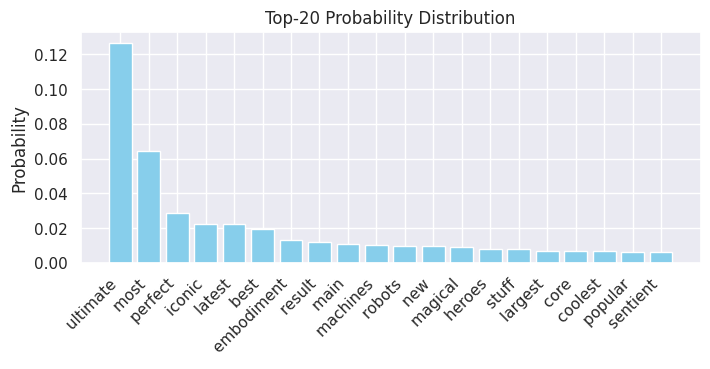

In [28]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='pdf', temperature=1.0,figsize=(8,3))

 and its cumulative distribution:

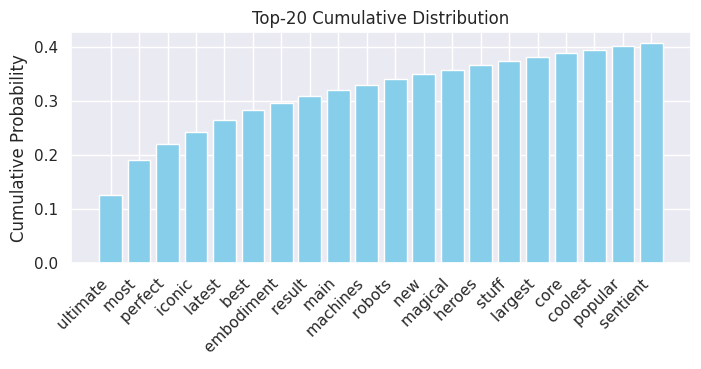

In [29]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='cdf', temperature=1.0, figsize=(8,3))

This is a great place to explore the role of the temperature parameter $T$ in this probability distribution.  The temperature is used to increase ($T>1$) or decrease ($0<T<1$) the randomness of the top_p and top_k sampling methods.  It doesn't have any effect on deterministic search methods like greedy decoding and beam search.

A small value of $T$ leads to a "sharper" probability distribution that places more emphasis on the early tokens so that top ranked words are much more likely to be selected. For example, many LLM's default to a value around $0.7$:

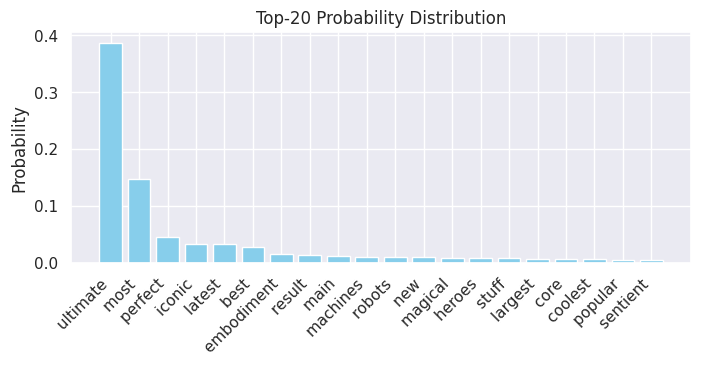

In [30]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='pdf', temperature=0.7,figsize=(8,3))

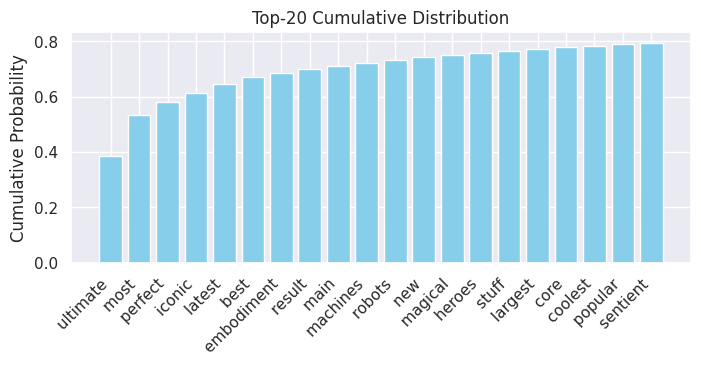

In [31]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='cdf', temperature=0.7,figsize=(8,3))

Conversely, a large value of temperature flattens the probability distribution making it closer to uniform.  This makes lower ranked words much more likely.  For example $T=1.3$ gives:

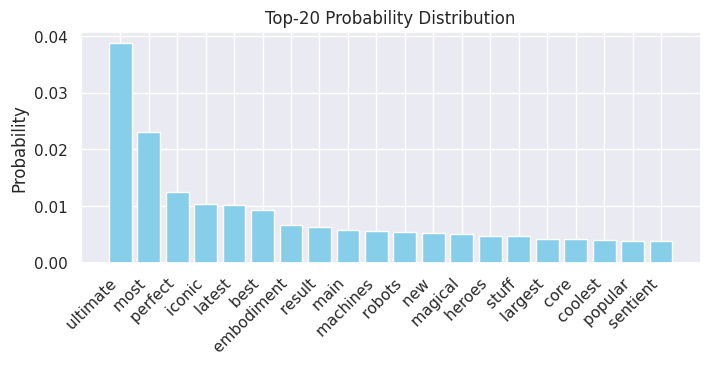

In [32]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='pdf', temperature=1.3,figsize=(8,3))

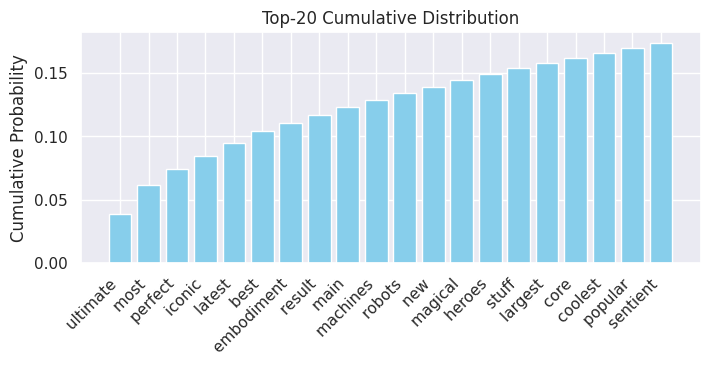

In [33]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='cdf', temperature=1.3,figsize=(8,3))

Now let's review the four main decoding strategies.  Each strategy stops when the maximum number of new tokens is reached or when a special "end of sequence" token is selected.

### The Greedy Decoding Strategy

This approach is called "greedy" because it greedily chooses the next token to be the token with the largest probability.  It's the fastest of the decoding methods.  This deterministic approach is good for tasks where consistency and coherency are more important than creativity like code-generation or factual question answering.

To better understand how it works lets show a sequence is generated by printing a table of the top 5 completions and appending the one with the largest probability at each iteration.   

In [43]:

# Example usage
prompt = "Transformers are the"
df = generate_greedy_decoding_table(model, tokenizer, prompt, max_length=10)
# Display with styling to limit width and wrap text
display(HTML(df.to_html(escape=False, notebook=True, max_rows=None)))

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,ultimate (12.66%),most (6.41%),perfect (2.87%),iconic (2.25%),latest (2.23%)
1,Transformers are the ultimate,symbol (17.35%),shape (6.84%),symbols (4.35%),action (2.33%),in (2.33%)
2,Transformers are the ultimate symbol,of (99.61%),for (0.07%),in (0.05%),and (0.02%),\n (0.02%)
3,Transformers are the ultimate symbol of,childhood (13.38%),the (8.37%),power (5.66%),(2.76%),nostalgia (2.40%)
4,Transformers are the ultimate symbol of childhood,wonder (21.17%),nostalgia (19.58%),imagination (14.55%),excitement (8.29%),play (3.80%)
5,Transformers are the ultimate symbol of childhood wonder,and (70.41%),", (16.47%)",. (9.83%),! (0.83%),– (0.44%)
6,Transformers are the ultimate symbol of childhood wonder and,excitement (42.46%),imagination (19.75%),play (6.02%),nostalgia (4.30%),adventure (4.14%)
7,Transformers are the ultimate symbol of childhood wonder and excitement,. (69.73%),", (14.84%)",! (8.33%),for (2.92%),in (2.01%)
8,Transformers are the ultimate symbol of childhood wonder and excitement.,Who (32.67%),These (16.17%),They (7.52%),From (6.85%),Whether (5.68%)
9,Transformers are the ultimate symbol of childhood wonder and excitement. Who,wouldn (42.72%),can (26.32%),doesn (12.24%),among (4.57%),needs (3.40%)


### Beam Search

Beam search is a decoding algorithm used to generate sequences in language models by maintaining a fixed number of the most probable sequences, called beams, at each step. Unlike greedy search, which selects only the highest-probability token at each step, beam search explores multiple possibilities and keeps the top num_beams sequences based on their cumulative probabilities. As the model generates tokens, beam search extends each beam by all possible next tokens and keeps only the top num_beams sequences. This approach helps balance quality and diversity of output compared to simpler methods like greedy search.  It's commonly used for machine translation, summarization, and other tasks requiring coherence.

I like the following description of beam search from [Inference Speed Is the Key To Unleashing AI's Potential](https://groq.com/wp-content/uploads/2024/05/2024_GroqThoughts_Inference-Speed-Is-the-Key-To-Unleashing-AIs-Potential.pdf) from the LLM API provider Groq:


"Beam search, for example, is a kind of 'search ahead'
technique that generates better results by looking ahead
at a possible set of outcomes, then selecting the best one
based on a scoring function. Think of a chess-playing bot
who, rather than just predicting its next move, gives itself
ten different next-move options and plays out the match
for each of those ten. It may discover that what it thought
was its best next move was in fact inferior to another
option. If it simply relies on its stream of consciousness, its
quality won’t be as good as it could be."

The following demo requires you to press "Enter" to seach each step of the beam search.  At each step we accumulate the sum of the log probabilities and select the top `num_beams` sequences.  Here we demonstrate beam search with just two beams and considering 3 possible completions of each beam at each iteration:

In [44]:
prompt = "Transformers are the"
df = generate_detailed_beam_search(model, tokenizer, prompt, num_beams=2, max_length=6, temperature=1.0);
display(df)



=== Step 6: Top 3 Completions for Each Beam ===


,Beam,Completion 1,Completion 2,Completion 3
0,Transformers are the most popular toys of all,time (0.9844),-time (0.0038),times (0.0035)
1,Transformers are the most popular toys of the,(0.3357),modern (0.1169),past (0.0597)



=== Step 6: Expanded Beams (Unsorted) ===


,Beam,Text,Previous Log Prob Sum,Log Prob of New Word,New Log Prob Sum
0,1,Transformers are the most popular toys of all time,-6.849609,-0.015747,-6.865356
1,2,Transformers are the most popular toys of all-time,-6.849609,-5.562500,-12.412109
2,3,Transformers are the most popular toys of all times,-6.849609,-5.640625,-12.490234
3,4,Transformers are the most popular toys of the,-7.381348,-1.091797,-8.473145
4,5,Transformers are the most popular toys of the modern,-7.381348,-2.146484,-9.527832
5,6,Transformers are the most popular toys of the past,-7.381348,-2.818359,-10.199707


None



Both beam search and greedy decoding are deterministic.  Now we'll consider top_k and top_p sampling which both generate random responses, but differ in how the probability distribution is used to select the next token.

### Top-k sampling

In top-k sampling, we randomly choose from the k tokens with the highest probabilities.  These probabilities are renormalized so that they sum to 1 at each step.  We then sample from the top-k tokens according to the renormalized probilities. Top-k sampling limits the possible randomness by using only the top-k tokens. It is useful for creative tasks where you want some diversity but not complete randomness.

The demo below below gives you an idea how this works.  You must press enter at each iteration to see the next sequence.  Try running it a few times to see how the results vary.  If you decrease the temperature (try 0.7 or 0.5) that should decrease the variability.  Similarly, increasing the temperature will increase the variation of the output sequences.

In [45]:
prompt = "Transformers are the"
df = generate_top_k_sampling(model, tokenizer, prompt, max_length=6, top_k = 5, temperature=1.0);
display(df)



=== Step 6 ===
Current Sequence: Transformers are the iconic robots from the popular


,Step,Completion 1,Completion 2,Completion 3,Completion 4,Completion 5
0,Original Probabilities,franchise (0.4688),animated (0.1301),Transformers (0.1014),toy (0.0983),cartoon (0.0373)
1,Renormalized Probabilities,franchise (0.5605),animated (0.1556),Transformers (0.1213),toy (0.1176),cartoon (0.0446)
2,Selected Completion,franchise,animated,Transformers,toy,cartoon


None


### Top-p Sampling (also called Nucleus Sampling)

In top-p sampling, we randomly choose from all the highest ranked tokens whose cumulative probability is approximately $p$.  For example if we're doing top-90% sampling, we first find the tokens that make up the top 90% of all possible tokens.  How many tokens this is varies at each step as the overall distribtion changes.  The probabilities corresponding to the top-p tokens are renormalized and then we randomly sample from those tokens according to the renormalized probabilities.  The set of tokens to be sampled is dynamic.  This method is more flexible than top-k and is often used where creativeness is important.

The demo below below gives you an idea how this works.  You must press enter at each iteration to see the next sequence.  Try running it a few times to see how the results vary.  If you decrease the temperature (try 0.7 or 0.5) that should decrease the variability.  Similarly, increasing the temperature will increase the variation of the output sequences.

Settings of `top_p = 0.9` and `temperature = 0.7` are very common in chatbot applications so we'll demonstrate with those here:

In [46]:

prompt = "Transformers are the"
generate_top_p_sampling(model, tokenizer, prompt, max_length=8, top_p=0.9, temperature=0.7)


=== Step 8 ===
Current Sequence: Transformers are the latest trend in the gaming world.


,Step,Completion 1,Completion 2,Completion 3,Completion 4,Completion 5,Completion 6,Completion 7,Completion 8
0,Original Probabilities,These (0.3418),They (0.2041),The (0.1298),With (0.1277),From (0.0428),But (0.0196),In (0.0155),If (0.0128)
1,Renormalized Probabilities,These (0.3823),They (0.2283),The (0.1451),With (0.1428),From (0.0479),But (0.0219),In (0.0173),If (0.0144)
2,Selected Completion,These,They,The,With,From,But,In,If


### Summary of the Decoding Methods

Here's a summary table comparing **various LLM decoding strategies**, their **typical use cases**, and **strengths and weaknesses**.


Got it! I've updated the table to **exclude `early_stopping`**, and we’ll address it separately when demonstrating the strategies with HuggingFace models in the next section.



| **Decoding Strategy** | **Typical Use Cases**                          | **Typical Parameters**                        | **Strengths**                           | **Weaknesses**                         |
|-----------------------|------------------------------------------------|---------------------------------------------|----------------------------------------|---------------------------------------|
| **Greedy Search**     | - Closed-form tasks (e.g., QA, summarization)  <br> - Code generation with deterministic results | `max_length=256`  | - Fast and efficient <br> - Produces consistent, coherent output | - Prone to repetition <br> - Lacks diversity and creativity |
| **Beam Search**       | - Machine translation <br> - Summarization <br> - Text completion where coherence is critical | `num_beams=4` <br> `max_length=256` | - High coherence <br> - Balances quality vs. diversity <br> - Returns multiple candidates | - Computationally expensive <br> - May produce bland or repetitive outputs |
| **Top-k Sampling**    | - Creative writing <br> - Dialog systems <br> - Story generation <br> - Poetry | `top_k=50` <br> `temperature=0.8` <br> `max_length=256` | - Encourages diversity <br> - Limits randomness by sampling from top-k tokens | - May still produce low-quality outputs <br> - Quality highly dependent on \( k \) |
| **Top-p Sampling (Nucleus Sampling)** | - Conversational AI <br> - Creative writing <br> - Dialogue generation | `top_p=0.9` <br> `temperature=0.7` <br> `max_length=256` | - High diversity <br> - More flexible than Top-k by adjusting cumulative probability | - May generate irrelevant or incoherent text if \( p \) is too high |
| **Temperature Scaling** (Usually combined with other strategies) | - Adjusting randomness across tasks <br> - Balancing creativity and coherence | `temperature=0.7` (for creative tasks) <br> `temperature=0.1` (for factual tasks) | - Can fine-tune creativity by adjusting temperature | - Poor choice of temperature can degrade performance (e.g., too low = deterministic, too high = chaotic) |




## **7 Implementing Decoding Strategies with Local and API-Based Models**

*This section was updated for Fall 2025.  The video was made with the previous version, but much is exactly the same.*

#### L11_1_Local_and_API_Decoding Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_local_and_api_decoding/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l11_1_local_and_api_decoding/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/dE6w75y0Wo1" target="_blank">Open Descript version of video in new tab</a>

In this section we'll demonstrate how to implement the various decoding methods with local and API-based models.  Watch the video above to get an explanation of the code in the next cell.

**Note:** We're not using chat roles or chat_template here to keep things simple, but you can.  You'd likely want to clean the output to display only the new output.  We demonstrated this in Section 5 above.


In [47]:
# Load the model and tokenizer (UNCOMMENT if don't already have them loaded)
# model_name  = "unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')

# Initial prompt
prompt = 'Transformers are the'
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(model.device)

print('Model and tokenizer loaded successfully.')

# Function to generate text
def generate_text(input_ids,**kwargs):
    output = model.generate(input_ids, **kwargs)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(generated_text)

# Greedy Search
print('\nDemonstrating Greedy Search...\n')
generate_text(
    input_ids,
    max_length=50,
    do_sample=False,  # Ensures deterministic output
    temperature=None,  # Greedy search does not use temperature, set to None to avoid warning
    top_p = None,  # Greedy search does not use top-p, set to None to avoid warning
)
# equal to model.generate(input_ids, max_length=50, do_sample=False, temperature=None, top_p=None)


# Beam Search
print('\nDemonstrating Beam Search...\n')
generate_text(
    input_ids, 
    max_length=50, 
    do_sample=False, # Ensures deterministic output
    num_beams=4,  # Number of beams for beam search
    early_stopping=True,  # Stops generation when the model predicts an end token
    temperature=None,  # Beam search does not use temperature, set to None to avoid warning
    top_p = None  # Beam search does not use top-p, set to None to avoid warning
)

# Top-k Sampling
print('\nDemonstrating Top-k Sampling...\n')
generate_text(
    input_ids,
    max_length=50,
    do_sample=True,   # Enables sampling
    top_k=50,         # Limits sampling to the top 50 tokens by probability
    temperature=0.8
)

# Top-p Sampling
print('\nDemonstrating Top-p Sampling...\n')
generate_text(
    input_ids,
    max_length=50,
    do_sample=True,
    top_p=0.9,        # Samples from the smallest set of tokens with cumulative probability >= 0.9
    temperature=0.7
)

print('\nAll decoding methods demonstrated successfully.')


Model and tokenizer loaded successfully.

Demonstrating Greedy Search...

Transformers are the ultimate symbol of childhood wonder and excitement. Who wouldn't want to
transform into a robot, a car, or a plane? But what if I told you that there's a way to bring the
magic of Transformers to your own

Demonstrating Beam Search...

Transformers are the ultimate shape-shifters, able to change their form to adapt to any situation.
But what if they could take it to the next level? What if they could not only change their shape,
but also their very essence?

In

Demonstrating Top-k Sampling...

Transformers are the best! I just wanted to say that. I love watching them change and grow and
evolve, it's like magic. I also love that they can take on different forms, it's like they have a
secret identity. I

Demonstrating Top-p Sampling...

Transformers are the perfect toy for kids of all ages, but did you know that they can also be a
great tool for learning and developing essential skills? Here a

### Decoding Strategies with API-Based Models

Now let's turn our attention to API-based models. Unlike local models that expose all decoding parameters, **API-based models typically provide access to only three main parameters**:

- **`temperature`** - Controls randomness (0 = greedy/deterministic, higher = more creative)
- **`top_p`** - Nucleus sampling (cumulative probability threshold)
- **`max_tokens`** - Maximum number of tokens to generate

**What's NOT available:**
- **`num_beams`** - Beam search is too computationally expensive for APIs
- **`top_k`** - Less common; `top_p` is the preferred sampling method
- **`do_sample`** - Not needed; setting `temperature=0` gives greedy decoding

These three parameters are sufficient for most practical applications and are part of the standard OpenAI API format used by most providers (OpenAI, OpenRouter, Google AI, Anthropic, etc.).


### Using Decoding Parameters with OpenAI APIs like OpenRouter

To use these parameters, simply add them to your `chat.completions.create()` call. Here's how to implement different strategies:

**Greedy Decoding (Deterministic):**
```python
response = client.chat.completions.create(
    model="google/gemini-2.5-flash-lite",
    messages=[{"role": "user", "content": "Your prompt here"}],
    temperature=0,      # Greedy: always pick most likely token
    max_tokens=50
)
```

**Top-P Sampling (Nucleus Sampling):**
```python
response = client.chat.completions.create(
    model="google/gemini-2.5-flash-lite",
    messages=[{"role": "user", "content": "Your prompt here"}],
    temperature=0.7,    # Moderate randomness
    top_p=0.9,          # Sample from top 90% cumulative probability
    max_tokens=50
)
```

Let's demonstrate these strategies with examples:


In [48]:
from openai import OpenAI
import os

# Initialize OpenRouter client
client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

prompt = "Transformers are the"

# Greedy Decoding (temperature=0)
print('=' * 70)
print('Demonstrating Greedy Search (temperature=0)...')
print('=' * 70)
response = client.chat.completions.create(
    model="google/gemini-2.5-flash-lite",
    messages=[{"role": "user", "content": prompt}],
    temperature=0,
    max_tokens=50
)
print(f"{prompt} {response.choices[0].message.content}\n")

# Top-p Sampling with moderate temperature
print('=' * 70)
print('Demonstrating Top-p Sampling (temperature=0.7, top_p=0.9)...')
print('=' * 70)
response = client.chat.completions.create(
    model="google/gemini-2.5-flash-lite",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.7,
    top_p=0.9,
    max_tokens=50
)
print(f"{prompt} {response.choices[0].message.content}\n")

# Higher temperature for more creativity
print('=' * 70)
print('Demonstrating High Temperature (temperature=1.2, top_p=0.95)...')
print('=' * 70)
response = client.chat.completions.create(
    model="google/gemini-2.5-flash-lite",
    messages=[{"role": "user", "content": prompt}],
    temperature=1.2,
    top_p=0.95,
    max_tokens=50
)
print(f"{prompt} {response.choices[0].message.content}")

print('\nAll API decoding strategies demonstrated successfully.')


Demonstrating Greedy Search (temperature=0)...
Transformers are the Transformers are the **foundation of modern natural language processing (NLP)**
and have revolutionized how we approach tasks involving sequential data, especially text.

Here's a breakdown of what they are and why they are so significant:

**What are Transformers?

Demonstrating Top-p Sampling (temperature=0.7, top_p=0.9)...
Transformers are the Transformers are the **foundation of modern natural language processing (NLP)**
and have revolutionized how we approach a wide range of AI tasks.

Here's a breakdown of what they are and why they're so significant:

**What are Transformers?

Demonstrating High Temperature (temperature=1.2, top_p=0.95)...
Transformers are the Transformers are a **type of neural network architecture** that has
revolutionized the field of Artificial Intelligence, particularly in Natural Language Processing
(NLP) and increasingly in other domains like computer vision.

Here's a breakdown of what m

### Key Differences: Local vs API Decoding

| Feature | Local Models | API Models |
|---------|--------------|------------|
| **Greedy Decoding** | `do_sample=False` | `temperature=0` |
| **Beam Search** | `num_beams=N` | ❌ Not available |
| **Top-k Sampling** | `top_k=N` | ❌ Rarely available |
| **Top-p Sampling** | `top_p=0.9` | ✓ `top_p=0.9` |
| **Temperature** | `temperature=T` | ✓ `temperature=T` |
| **Max Length** | `max_length=N` | ✓ `max_tokens=N` |

**Why these limitations?**
- APIs prioritize **simplicity** and **cost-effectiveness**
- Beam search is too expensive to expose at scale
- `temperature` + `top_p` provide excellent control for most use cases
- The OpenAI API format has become the de facto standard

**In your homework**, you'll practice using these parameters to control model behavior for different tasks.


## 8.  Adapting LLMs for Specialized Use

*This section is for background.  If your organization gets into LLMs you'll very likely be exploring both of the methods below.*

Whether for data security concerns or for specialized products it's often necessary to customize an LLM.  There are two main approaches for adapting them to specialized tasks: **fine-tuning** and **retrieval-augmented generation (RAG)**.

We aren't going to cover the details in this course, but this will give you enough to get started in a search to learn more.

#### Fine-Tuning

Fine-tuning involves training an already pre-trained LLM on a specific dataset to make it more effective for a specialized task. This can include tasks like **sentiment analysis, named entity recognition, or custom dialogue systems**.

A common approach to fine-tuning involves **training all the model’s parameters**, but this can be resource-intensive. More efficient methods include:

- **Adapters:** Lightweight modules inserted into the model’s architecture to learn task-specific adjustments without modifying the original model weights. They significantly reduce computational and storage costs while maintaining high performance. Adapters can be particularly useful when fine-tuning large models on smaller datasets.

For more on fine-tuning and adapters, see:
- [Hugging Face Course on Fine-Tuning](https://huggingface.co/course/chapter11/1?fw=pt)
- [Adapters Package Documentation](https://adapterhub.ml/)

#### Retrieval-Augmented Generation (RAG)

RAG enhances LLMs by allowing them to access **external sources of knowledge** during inference. Instead of relying solely on the model’s fixed knowledge, RAG systems:

1. **Retrieve** relevant documents or information from a database or search index.
2. **Generate** a response conditioned on both the prompt and the retrieved documents.

RAG is especially useful when the model needs access to **up-to-date or domain-specific information** that was not part of its training data.

For more on RAG, see:
- [Hugging Face RAG Documentation](https://huggingface.co/transformers/model_doc/rag.html)
- [LangChain's RAG Page](https://python.langchain.com/docs/concepts/rag/) - many links here
